# Control of an epidemiological SIR model with maximum health-care capacity
The purpose of this notebook is to provide some code that will result in information regarding a particular epidemiologcial SIR model with a set of constraints. The system is given by the set of differential equations
$$
\begin{aligned}
\dot{S} &= -(1 - u) \beta S I \\
\dot{I} &= (1 - u) \beta S I - \gamma I \\
\dot{R} &= \gamma I
\end{aligned}
$$
with $\beta$ a rate of infection, $\gamma$ a rate of recovery, and $u \in [0, 1)$ a control over the infection rate that resembles a quarantine. The intent of the following code is to generate the quickest trajectory between an initial point $P$, and a safe zone in which the epidemic can be set to evolve naturally *withouth* exceeding a parameter $I_{max}$ that represents the maximum capacity of the health system.

## Generate trajectory for a given point.
First of all, we will need to import some modules and set some variables.

In [1]:
import sir
import matplotlib.pyplot as plt
import numpy as np

In [2]:
### Set your parameters. The class always takes imax and umax, but can handle either beta/gamma or r0. Set the ones you
### wish to use, and leave the rest as None.
imax = 0.1
umax = 0.5
gamma = 0.2
beta = 0.5
r0 = None

if r0 is None:
    A = sir.SIR()
    A.set_params([imax, umax, gamma, beta], flag = "bg") # The flag determines the type of parameters used.
elif beta is None and gamma is None:
    A = sir.SIR()
    A.set_params([imax, umax, r0], flag = "r")

In [3]:
### Set an initial point for your system, get important features, and find the trajectory of least time to the safe
### zone. Set said point to P.
s0, i0 = [0.8, 0.06]
P = A.add_point(s0, i0)

# The trajectory construction depends on the location of the point with regards to of a set of curves. First, the
# curves need to be found, and then the location of each point needs to be determined. This is all done in the
# background by the method SIR.find_region(point).
A.find_region(P)

# Find the shortest trajectory between all points and the safe region defined by A.tau. Assign one of them to the
# variable T.
A.get_shortest()
T = P.least_time

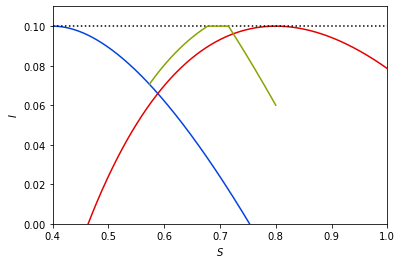

In [4]:
fig, ax = plt.subplots()
ax.set_xlim(A.sbar, 1)
ax.set_xlabel(r"$S$")
ax.set_ylim(0, A.imax*1.1)
ax.set_ylabel(r"$I$")
ax.plot(A.tau.s, A.tau.i, color = "xkcd:blue", linestyle = "-")
ax.plot(A.phi.s, A.phi.i, color = "xkcd:red", linestyle = "-")
ax.plot([A.sbar, 1], [A.imax, A.imax], color = "xkcd:black", linestyle = ":")
ax.plot(T.s, T.i, color = "xkcd:vomit green", linestyle = "-")

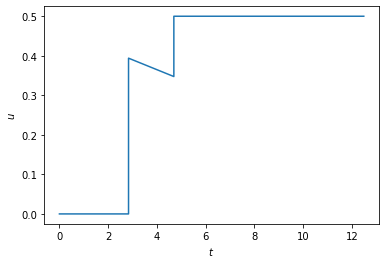

In [5]:
T.plot_time()

The above two figures show two different things. First of all, the top figure shows the evolution of the trajectory through the $S-I$ plane. We can see that this particular instance has a first segment of curve with $u = 0$, then a line segment along the singular arc, and finally another curve segment with $u = u_{max}$ that reaches $\tau$. This can be seen through an attribute of the Trajectory object called segments, as shown bellow.

The second curve shows the required control from the start to the end of the trajectory.

In [6]:
print(T.segments)

(Curve segment:
	u = 0.00
	s_ref = 0.80
	i_ref = 0.06
	t = 2.83
, Singular Curve:
	s0 = 0.72
	sf = 0.68
	u = 0.39 to 0.35
	t = 1.86
, Curve segment:
	u = 0.50
	s_ref = 0.68
	i_ref = 0.10
	t = 7.79
)


## Find commutation curve
Each system has a curve in the $S-I$ plane at which the least-time trajectories commute. The following code finds said curve.

In [7]:
### Instantiate the system and parameters.
imax = 0.1
umax = 0.5
gamma = 0.2
beta = 0.5
r0 = None

if r0 is None:
    A = sir.SIR()
    A.set_params([imax, umax, gamma, beta], flag = "bg")
elif beta is None and gamma is None:
    A = sir.SIR()
    A.set_params([imax, umax, r0], flag = "r")

In [8]:
### Create a set of initial conditions to get the commutation curve.
disp = 1e-3

# How far low on I the initial conditions go. The further down, the more information on the lower region of the curve
ilow = 5e-4

s0, i0 = sir.create_initial_conditions(A, disp, ilow)

In [9]:
for ss, ii in zip(s0, i0):
    A.add_point(ss, ii)

# Instead of iterating manually through all points in A.points and finding their regions, a method has been implemented
# which does if for you.
A.find_regions()
A.get_shortest()

M = np.array([p.least_time for p in A.points])
fp = np.array([tra.s[-1] for tra in M])

Text(0, 0.5, '$S_f$')

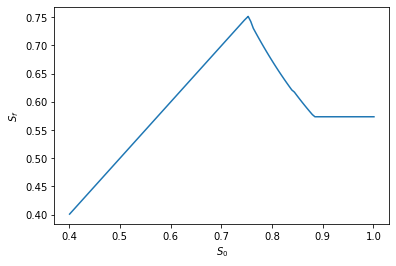

In [11]:
fig, ax = plt.subplots()
ax.plot(s0, fp)
ax.set_xlabel(r"$S_0$")
ax.set_ylabel(r"$S_f$")

The above figure shows the relationship between the $S$-coordinate of the initial point, and the $S$-coordinate of the final point. The initial points that go through the commutation point are the ones in which the curve has a negative gradient, as the final point starts going back. The next cell finds these points, creates a set of initial conditions between them, and repeats the above code. Thus, the commutation curve can be found.

In [17]:
st, end, b = sir.find_criticals(s0, fp)
s0, i0 = sir.create_initial_conditions(A, disp, ilow, st, end, size = 100)
A.remove_all_points()

for ss, ii in zip(s0, i0):
    A.add_point(ss, ii)

A.find_regions()
A.get_shortest()
M = np.array([p.least_time for p in A.points])
fp = np.array([tra.s[-1] for tra in M])

Text(0, 0.5, '$S_f$')

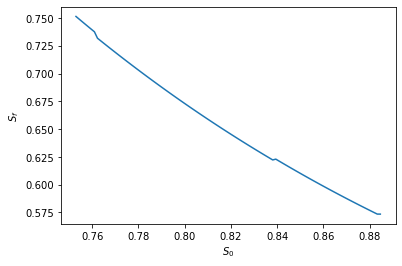

In [18]:
fig, ax = plt.subplots()
ax.plot(s0, fp)
ax.set_xlabel(r"$S_0$")
ax.set_ylabel(r"$S_f$")

The commutation point for the trajectories in this domain of $S$ are also its maxima. So, we identify the maxima and plot them.

In [19]:
cp_s = np.zeros(np.shape(M), dtype = float)
cp_i = np.zeros(np.shape(M), dtype = float)

for ii in range(np.shape(M)[0]):
    x, y = sir.find_max(M[ii])
    cp_s[ii] = x
    cp_i[ii] = y

A.commutation_curve = [cp_s, cp_i]

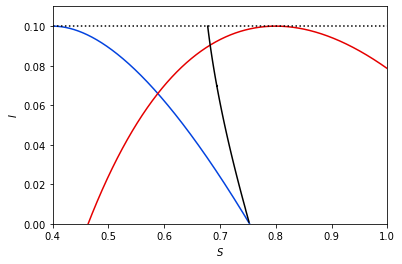

In [20]:
fig, ax = plt.subplots()
ax.set_xlim(A.sbar, 1)
ax.set_xlabel(r"$S$")
ax.set_ylim(0, A.imax*1.1)
ax.set_ylabel(r"$I$")
ax.plot(A.tau.s, A.tau.i, color = "xkcd:blue", linestyle = "-")
ax.plot(A.phi.s, A.phi.i, color = "xkcd:red", linestyle = "-")
ax.plot(A.commutation_curve[0], A.commutation_curve[1], color = "xkcd:black", linestyle = "-")
ax.plot([A.sbar, 1], [A.imax, A.imax], color = "xkcd:black", linestyle = ":")

The above figure shows four things. First of all, in a solid blue line, the borders of the safe zone, called $\tau$. Once this region is reached, there is no need to use any more controls and the epidemic can be "set loose". Second, in a dotted black line, $I_{max}$. Third, in a solid black line, the commutation curve. Any least-time trajectory to the right of this curve, has $u = 0$. Any least-time trajectory to its left, has $u = u_{max}$.

A last curve called $\phi$, shown in a solid red line, is another border of the system. Any point to the right of this curve (with some exceptions that will not be discussed here) cannot reach $\tau$ without exceeding $I_{max}$, even using $u_{max}$ from $t = 0$. The best strategy defined for such points, and points above $I_{max}$, is to start the trajectory with $u = u_{max}$.

This set of curves divides the plane into two regions:
 * Those points to the left of $\tau$ or between the commutation curve and $\phi$, require $u = 0$.
 * Those points between $\tau$ and the commutation curve, to the right of $\phi$ or above $I_{max}$ require $u = u_{max}$.

## Curves with uncertain parameters
Sometimes, the exact value of a parameter is unknown. Hence, it might be necessary to see how the curves mentioned above vary with parameter variation. This can be done by making a list of values (min and max), and iterating through it. Below, an example varying the value of $R_0$ (note that this is equivalent to varying $\beta$, as the code fixes $\gamma$ to 1/7. If this value is to be changed, iterating through both $\beta$ and $\gamma$ rather than $R_0$ is probably better).

In [21]:
r0 = [2.1, 2.5] # In this case, best-case-scenario and worst-case-scenario.
imax = 0.1
umax = 0.5

disp = 1e-3
ilow = 5e-4

scenarios = {"bcs": None, "wcs": None}

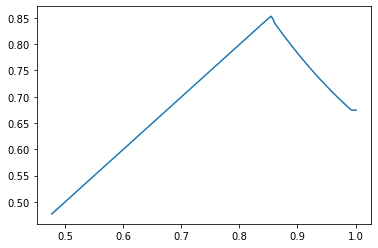

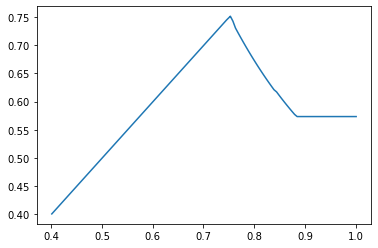

In [23]:
for ii in range(len(r0)):
    r = r0[ii]
    key = list(scenarios.keys())[ii]
    A = sir.SIR()
    A.set_params([imax, umax, r], flag = "r")
    scenarios[key] = A
    s0, i0 = sir.create_initial_conditions(A, disp, ilow)
    
    for ii, jj in zip(s0, i0):
        A.add_point(ii, jj)
    
    A.find_regions()
    A.get_shortest()
    M = np.array([p.least_time for p in A.points])
    
    final_point = np.array([tra.s[-1] for tra in M])
    fig, ax = plt.subplots()
    ax.plot(s0, final_point)
    
    st, end, b = sir.find_criticals(s0, final_point)    
    s0, i0 = sir.create_initial_conditions(A, disp, ilow, st, end, size = 100)
    
    A.remove_all_points() # Added so the points are not duplicated.
    for ii, jj in zip(s0, i0):
        A.add_point(ii, jj)
    
    A.find_regions()
    A.get_shortest()
    M = np.array([p.least_time for p in A.points])
    
    bp_s = np.zeros([len(M), ])
    bp_i = np.zeros([len(M), ])

    for ii in range(len(M)):
        x, y = sir.find_max(M[ii])
        bp_s[ii] = x
        bp_i[ii] = y
    
    A.commutation_curve = [bp_s, bp_i]

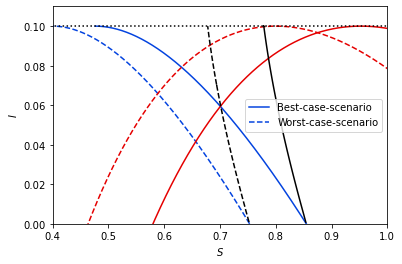

In [24]:
wcs = scenarios["wcs"]
bcs = scenarios["bcs"]

fig, ax = plt.subplots()
ax.set_xlim(wcs.sbar, 1)
ax.set_xlabel(r"$S$")
ax.set_ylim(0, wcs.imax*1.1)
ax.set_ylabel(r"$I$")
ax.plot(bcs.tau.s, bcs.tau.i, color = "xkcd:blue", linestyle = "-")
ax.plot(wcs.tau.s, wcs.tau.i, color = "xkcd:blue", linestyle = "--")
ax.plot(bcs.phi.s, bcs.phi.i, color = "xkcd:red", linestyle = "-")
ax.plot(wcs.phi.s, wcs.phi.i, color = "xkcd:red", linestyle = "--")
ax.plot(bcs.commutation_curve[0], bcs.commutation_curve[1], color = "xkcd:black", linestyle = "-")
ax.plot(wcs.commutation_curve[0], wcs.commutation_curve[1], color = "xkcd:black", linestyle = "--")
ax.plot([0, 1], [imax, imax], color = "xkcd:black", linestyle = ":")
ax.legend(["Best-case-scenario", "Worst-case-scenario"])

## Error estimation
It might happen that the curve does not go "as planned" when there is an uncertainty in one of the parameters. We are going to evaluate the robustness to uncertainty in two parameters: $u_{max}$ and $R_0$. This is going to be done with an error estimator defined as
$$ E = \dfrac{I_{max} - max_t(I)}{I_{max}} $$
which compares the maximum value of $I$ reached in a least-time trajectory, with the value of the maximum infected load $I_{max}$. Basically, it tells us if the trajectories reach the singular arc or bounce off the commutation curve before.

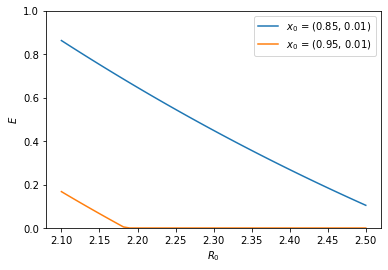

In [26]:
s1, i1 = [0.85, 0.01]
s2, i2 = [0.95, 0.01]
r0 = np.linspace(2.1, 2.5)
ni1 = np.zeros(np.shape(r0), dtype = float)
ni2 = np.zeros(np.shape(r0), dtype = float)

for ii in range(np.shape(r0)[0]):
    r = r0[ii]
    B = sir.SIR()
    B.set_params([imax, umax, r], flag = "r")
    P1 = B.add_point(s1, i1)
    P2 = B.add_point(s2, i2)
    B.find_regions()
    B.get_shortest()
    M1 = P1.least_time
    M2 = P2.least_time
    tim1 = max(M1.i)
    tim2 = max(M2.i)
    ni1[ii] = (imax - tim1) / imax
    ni2[ii] = (imax - tim2) / imax

fig, ax = plt.subplots()
ax.set_xlabel(r"$R_0$")
ax.set_ylim(0, 1)
ax.set_ylabel(r"$E$")
ax.plot(r0, ni1)
ax.plot(r0, ni2)
ax.legend(["$x_0$ = (0.85, 0.01)", "$x_0$ = (0.95, 0.01)"])

C:\Users\Rodrigo\Documents\sir\sir.py:545: RuntimeWarning: invalid value encountered in double_scalars
  s_intersect = np.exp(num/denom)
C:\Users\Rodrigo\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Rodrigo\Documents\sir\sir.py:545: RuntimeWarning: divide by zero encountered in double_scalars
  s_intersect = np.exp(num/denom)
C:\Users\Rodrigo\Documents\sir\sir.py:495: RuntimeWarning: divide by zero encountered in log
  p2 = np.log(s / s_0)
C:\Users\Rodrigo\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


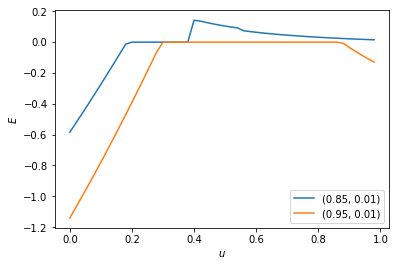

In [19]:
r0 = 2.5
imax = 0.1
umax = np.linspace(0.0, 1.0, endpoint = False)

s1, i1 = [0.85, 0.01]
s2, i2 = [0.95, 0.01]
ni1 = np.zeros(np.shape(umax), dtype = float)
ni2 = np.zeros(np.shape(umax), dtype = float)

for ii in range(np.shape(umax)[0]):
    u = umax[ii]
    #print(u)
    B = sir.SIR()
    B.set_params([imax, u, r0], flag = "r")
    P1 = B.add_point(s1, i1)
    P2 = B.add_point(s2, i2)
    B.find_regions()
    #print(P1.region, P2.region)
    B.get_shortest()
    M1 = P1.least_time
    M2 = P2.least_time
    tim1 = max(M1.i)
    tim2 = max(M2.i)
    ni1[ii] = (imax - tim1) / imax
    ni2[ii] = (imax - tim2) / imax

fig, ax = plt.subplots()
ax.set_xlabel(r"$u$")
#ax.set_ylim(0, 1)
ax.set_ylabel(r"$E$")
ax.plot(umax, ni1)
ax.plot(umax, ni2)
ax.legend(["({}, {})".format(s1, i1), "({}, {})".format(s2, i2)])
#fig.savefig("docs/u_imax.jpg", format = "jpg")
#fig.savefig("docs/u_imax.pdf", format = "pdf")